In [1]:
# Set Directories

jasmin = True  # Set to True if running on JASMIN, False if on local machine
jasmin_user_name = "trr26"

if jasmin:
    MAIN_DIR = f"/gws/nopw/j04/ai4er/users/{jasmin_user_name}/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data/gtc_quakes_data"

else:  # update directory names to match your local machine
    MAIN_DIR = f"/home/tom-ratsakatika/VSCode/earthquake-predictability"
    DATA_DIR = f"{MAIN_DIR}/data_local"

p4679_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4679/p4679.txt"
p4581_FILE_PATH = f"{DATA_DIR}/labquakes/Marone/p4581/p4581.txt"

# Imports

import os
import random
import sys
sys.path.append(MAIN_DIR)
import utils

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import local modules - note: dependent on above path being set.
# from utils.nn_io import loItad_model, save_model
from utils.general_functions import set_seed, set_torch_device
from utils.data_preprocessing import moving_average_causal_filter, compare_feature_statistics, create_dataset, split_train_test_forecast_windows, normalise_dataset
from utils.plotting import plot_original_vs_processed_data, plot_example_sample, plot_metric_results, plot_all_data_results
from utils.nn_train import train_model
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.general_functions import set_seed, set_torch_device

# Set random seed
SEED = 42 # random seed for the dataset and model
set_seed(SEED)


In [2]:
# Check CUDA Availability

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [3]:
def data_loader(exp):

    df_p4679 = pd.DataFrame()
    df_p4581 = pd.DataFrame()

    if "p4679" in exp:
        # Open the file located at p4679_FILE_PATH in read mode
        with open(p4679_FILE_PATH, "r") as file:
            # Read the file as a CSV using pandas, considering whitespace as delimiter
            # Skip the first 4 rows as they do not contain relevant data
            df_p4679 = pd.read_csv(file, skiprows=1)

        # Rename the columns of the DataFrame to align with the variable names used by Adriano's data loader
        df_p4679.columns = [
            "id",
            "lp_disp",
            "shr_stress",
            "nor_disp",
            "nor_stress",
            "time",
            "mu",
            "layer_thick",
            "ec_disp",
        ]

        # Drop columns not needed for further analysis
        df_p4679 = df_p4679.drop(
            [
                "id",
                "lp_disp",
                "nor_disp",
                "mu",
                "nor_stress",
                "layer_thick",
                "ec_disp",
            ],
            axis=1,
        )

        # Reorder the DataFrame columns to bring 'time' to the front
        df_p4679 = df_p4679[["time"] + [col for col in df_p4679.columns if col != "time"]]

        # Define start and end times for the data selection
        start_time = 4233.364
        end_time = 5159.292

        df_p4679 = df_p4679[(df_p4679["time"] >= start_time) & (df_p4679["time"] <= end_time)]
        df_p4679 = df_p4679.reset_index(drop=True)

        print(df_p4679.shape)
    
    if "p4581" in exp:

        # Open the file located at p4581_FILE_PATH in read mode
        with open(p4581_FILE_PATH, "r") as file:
            # Read the file as a CSV using pandas, considering whitespace as delimiter
            # Skip the first 4 rows as they do not contain relevant data
            df_p4581 = pd.read_csv(file, delim_whitespace=True, skiprows=4)

        # Rename the columns of the DataFrame to align with the variable names used by Adriano's data loader
        df_p4581.columns = [
            "id",            # Identifier
            "lp_disp",       # Lateral displacement
            "shr_stress",    # Shear stress
            "nor_disp",      # Normal displacement
            "nor_stress",    # Normal stress
            "time",          # Time of measurement
            "sync",          # Synchronization marker
            "samp_freq",     # Sampling frequency
        ]


        # Drop columns not needed for further analysis
        df_p4581 = df_p4581.drop(
            [
                "id",
                "lp_disp",
                "nor_disp",
                "nor_stress",
                "sync",
                "samp_freq",
            ],
            axis=1,
        )

        # Reorder the DataFrame columns to bring 'time' to the front
        df_p4581 = df_p4581[["time"] + [col for col in df_p4581.columns if col != "time"]]

        # Define start and end times for the data selection
        start_time = 2100
        end_time = 4800

        df_p4581 = df_p4581[(df_p4581["time"] >= start_time) & (df_p4581["time"] <= end_time)]
        df_p4581 = df_p4581.reset_index(drop=True)

        print(df_p4581.shape)
 
    df = pd.concat([df_p4679, df_p4581], axis=0)
    df = df.reset_index(drop=True)
    
    return df

In [4]:
# Load data from one or multiple experiments

exp = "p4679"       #["p4679", "p4581"]
df = data_loader(exp)
df.head()

(925929, 2)


,time,shr_stress
0,4233.364,4.896073
1,4233.365,4.896399
2,4233.366,4.896361
3,4233.367,4.896516
4,4233.368,4.896223


In [5]:
SMOOTHING_WINDOW = 1 # moving average window size
DOWNSAMPLING_FACTOR = 100

# Smooth the data
df_smoothed = moving_average_causal_filter(df["shr_stress"], SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_smoothed.shape

(9259,)

In [6]:
results = compare_feature_statistics(df["shr_stress"], df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': -0.030742611710719542, 'p_value': 0.9754748145383696, 'significant': False}, 'variance_comparison': {'f_statistic': 0.0009451081749484191, 'p_value': 0.9754748148229618, 'significant': False}}


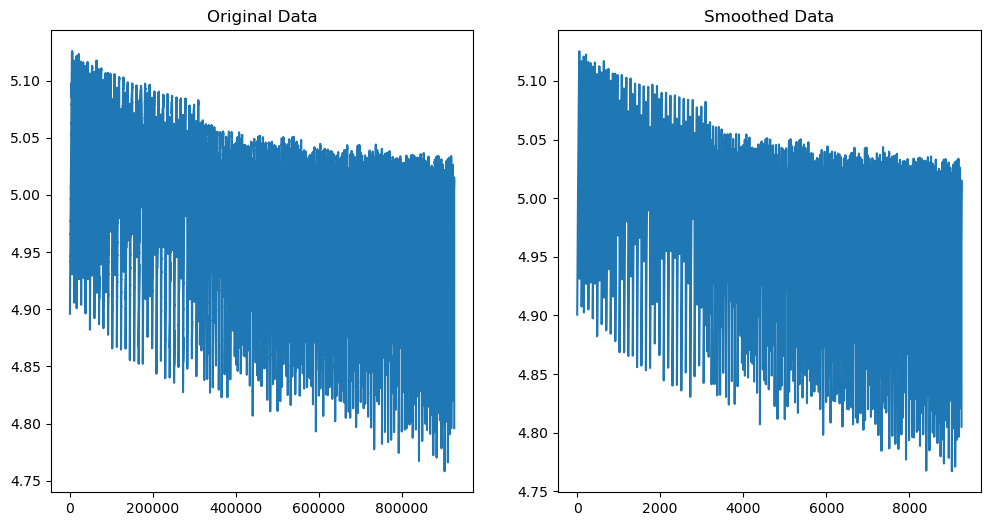

In [7]:
plot_original_vs_processed_data(df["shr_stress"], df_smoothed, "line")

In [8]:
# Dataset parameters
LOOKBACK, FORECAST = 90, 30 # lookback and forecast values
N_FORECAST_WINDOWS = 60 # n forecasted windows in test set

# Pre-process the data into windows
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([9140, 90]), torch.Size([9140, 30])


In [9]:
# Split into train and test sets and normalise it
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(X, y, FORECAST, N_FORECAST_WINDOWS)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([7320, 90]), torch.Size([7320, 30])
Testing data shapes: torch.Size([1800, 90]), torch.Size([1800, 30])


In [10]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = normalise_dataset(X_train, y_train, X_test, y_test)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])


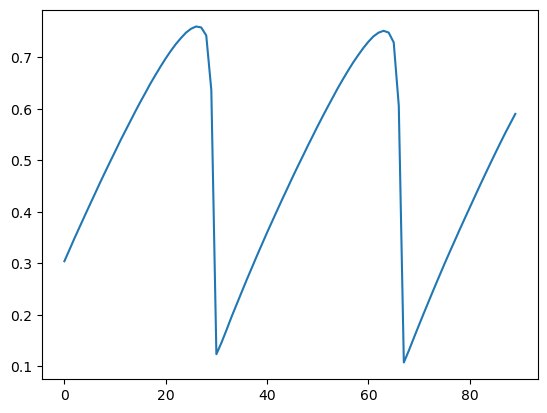

In [11]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

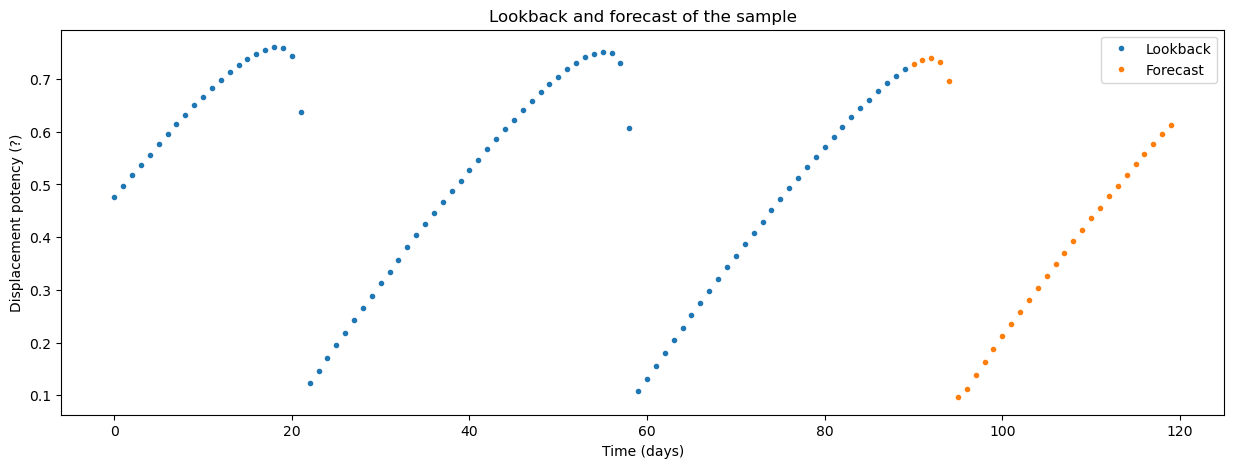

In [12]:
plot_example_sample(data_dict["X_test_sc"], data_dict["y_test_sc"], 10, LOOKBACK, FORECAST)

In [13]:
# For TCN config
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0

model = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE,  DROPOUT).to(device)

/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [14]:
# For TCN training
N_EPOCHS = 180
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [180/180], RMSE Train: 0.0211, RMSE Test: 0.0348: 100%|██████████| 180/180 [02:50<00:00,  1.06it/s]


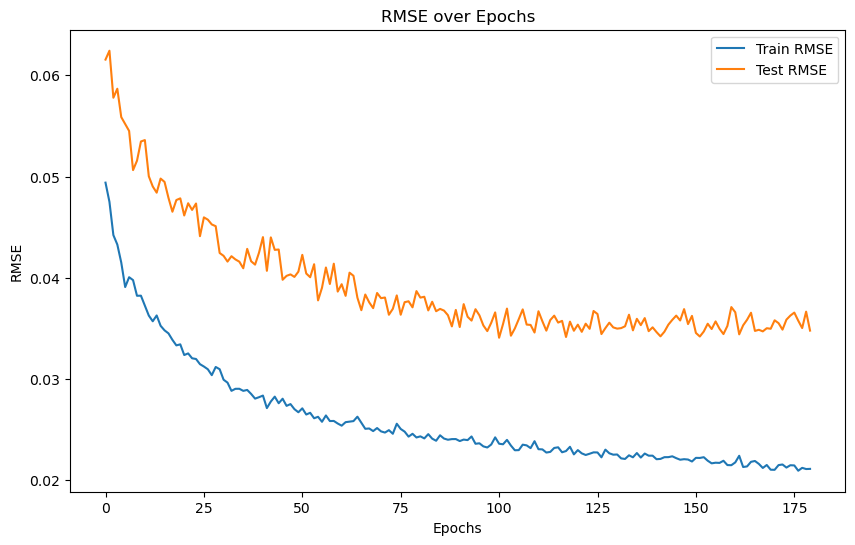

In [15]:
# Plot RMSE
plot_metric_results(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

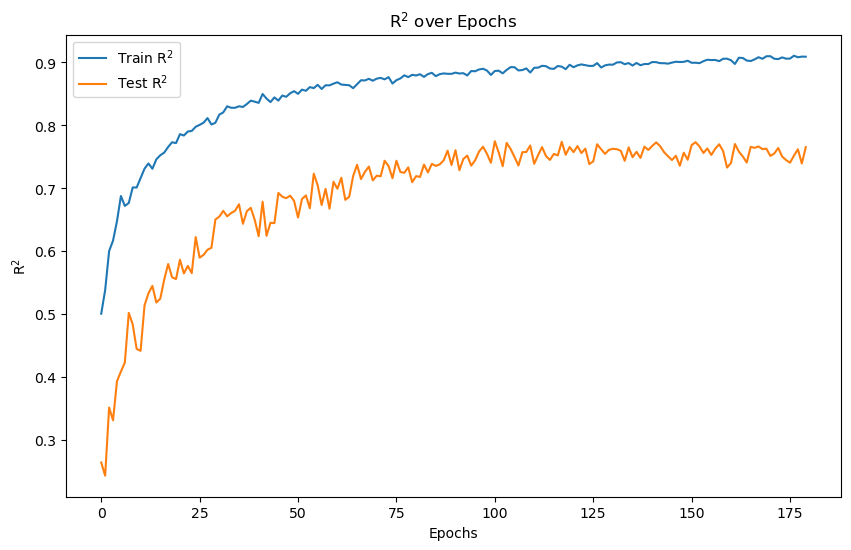

In [16]:
# Plot R2
plot_metric_results(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [20]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test) - LOOKBACK
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 8000
ZOOM_MAX = 8200
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

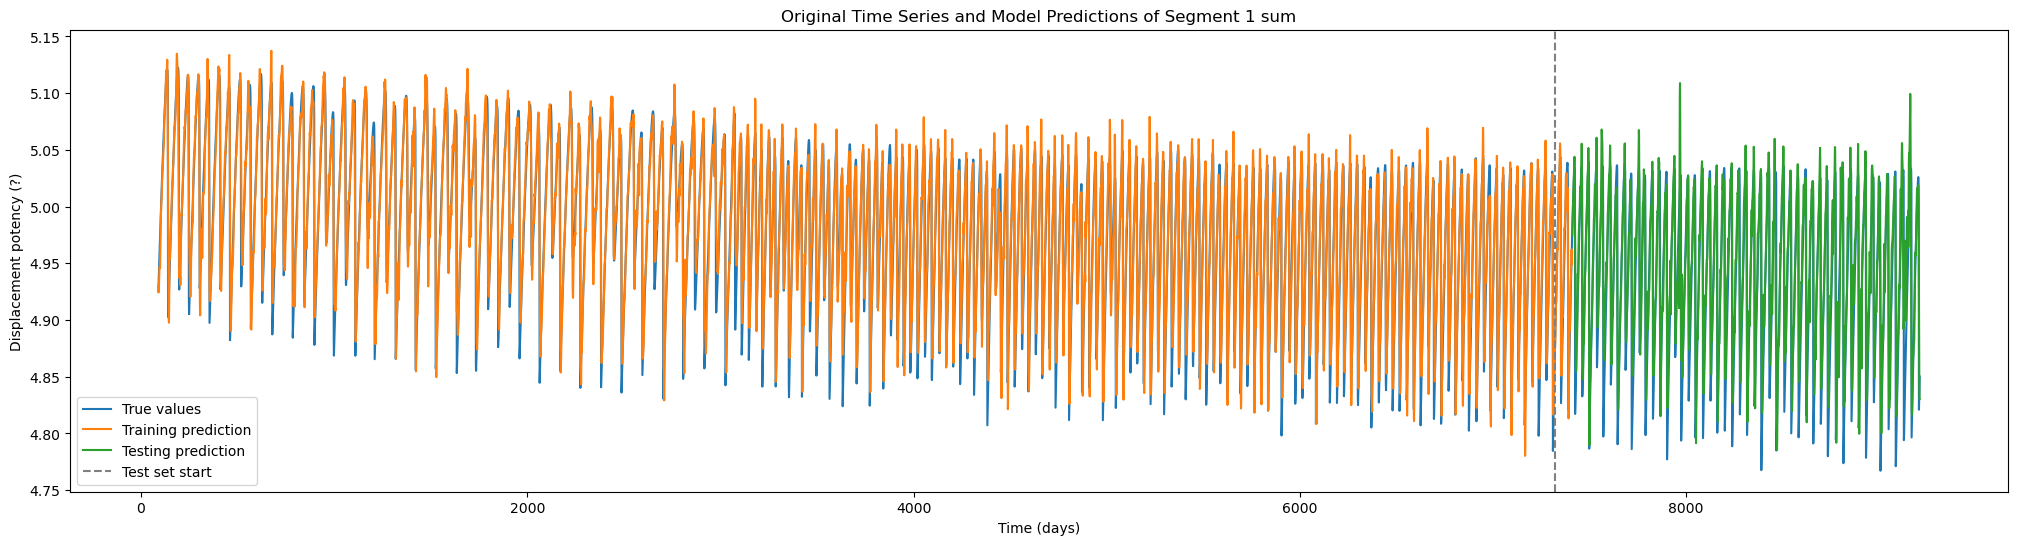

In [21]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


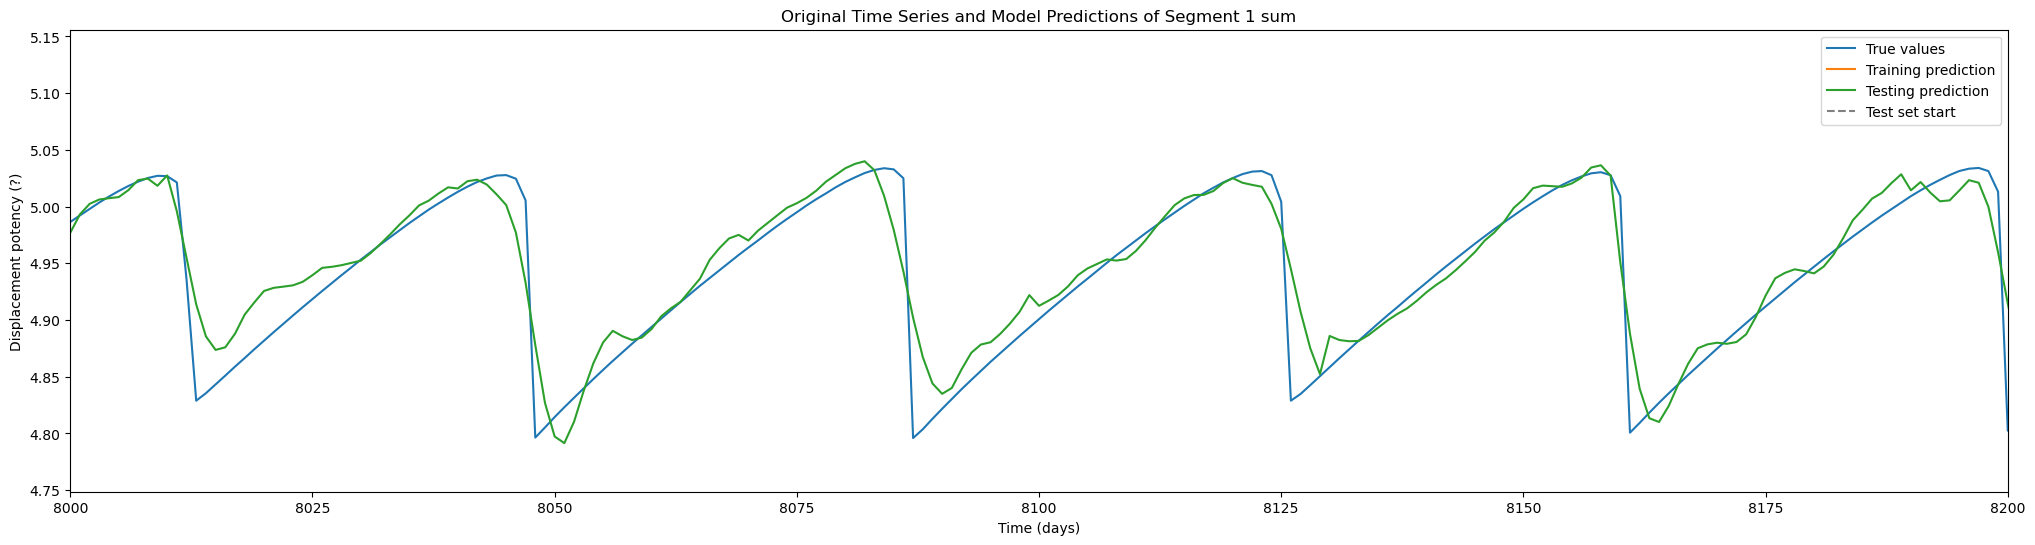

In [22]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)
# LOOK AT BOKE

In [26]:
# For LSTM config

import scripts.models.lstm_oneshot_multistep as lstm

N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

In [33]:
# For LSTM training
N_EPOCHS = 180
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [180/180], RMSE Train: 0.0144, RMSE Test: 0.0426: 100%|██████████| 180/180 [01:52<00:00,  1.61it/s]


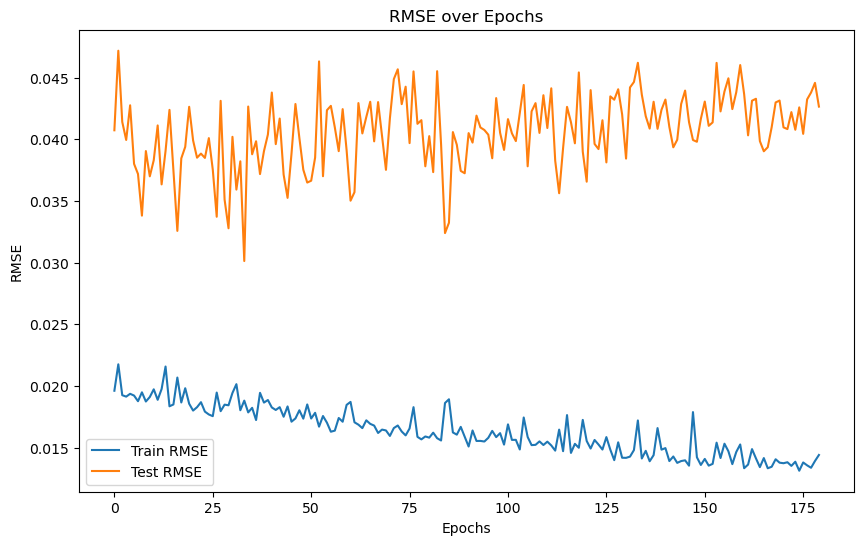

In [34]:
# Plot RMSE
plot_metric_results(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

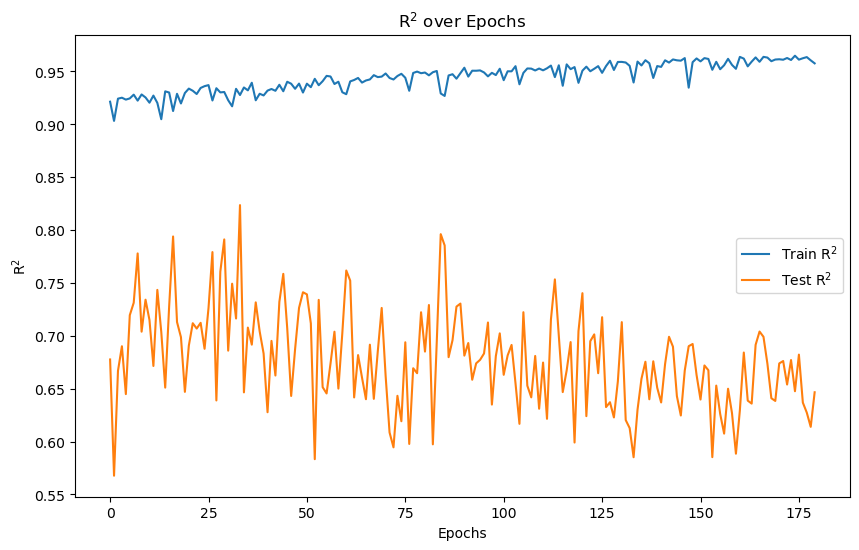

In [35]:
# Plot R2
plot_metric_results(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [36]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test) - LOOKBACK
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 8000
ZOOM_MAX = 8200
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

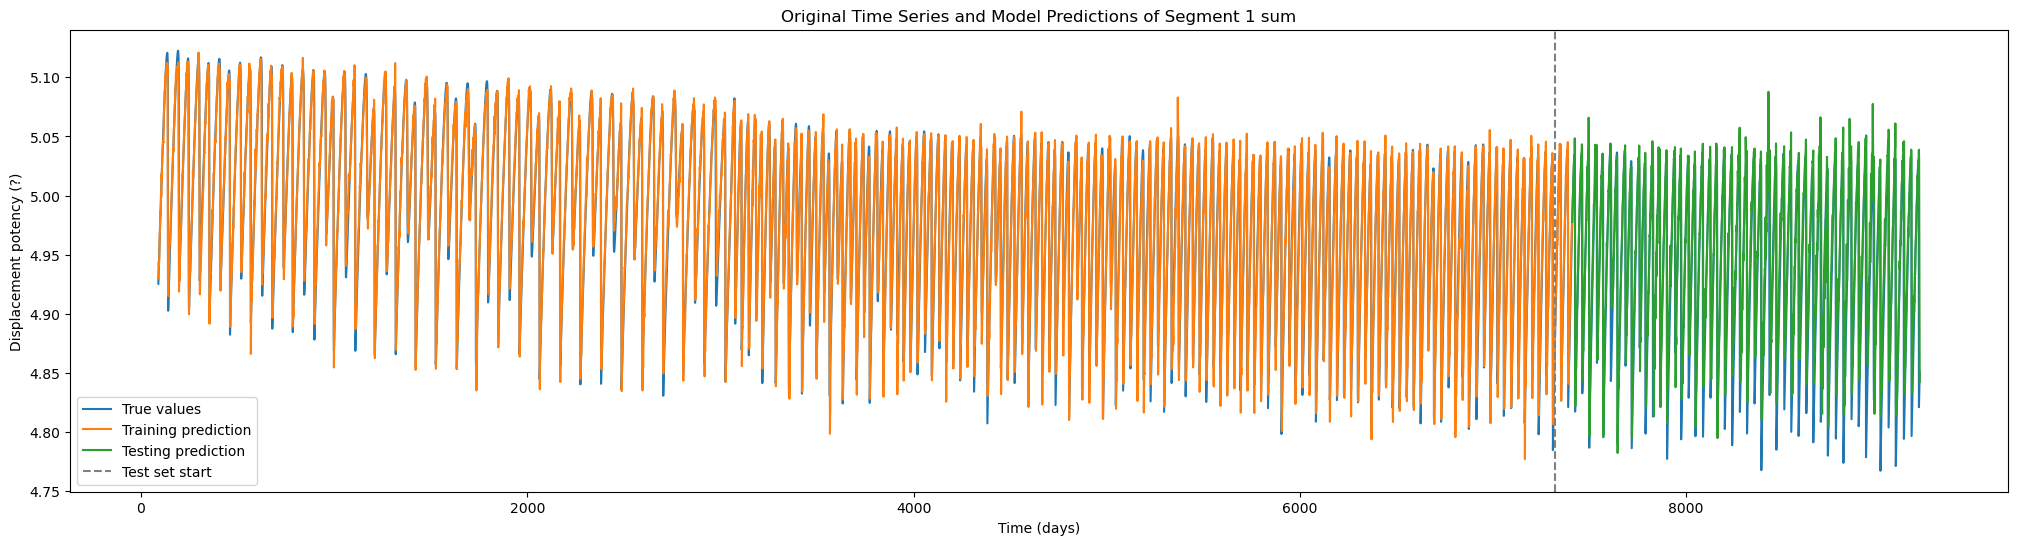

In [37]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


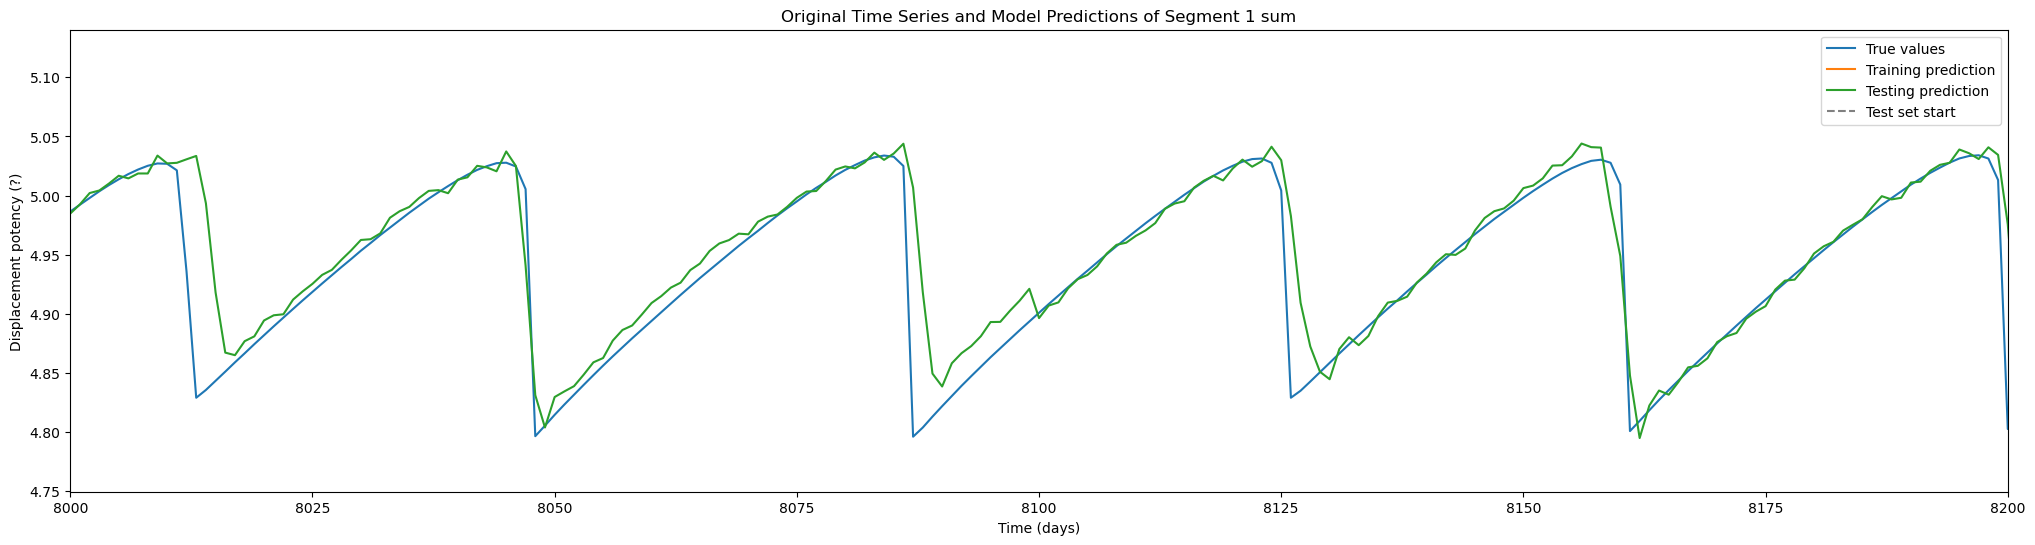

In [38]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)
# LOOK AT BOKE